In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
sys.path.insert(0, '../src/')
import helpers as h
%matplotlib inline

In [2]:
n_samples = 4
n_samples_fold = (n_samples+1)//2

# msprime

## Import data

In [3]:
def get_data(file_list, r_list, n_samples):
    data = h.import_msprime_corr(file_list, n_samples)
    pi, sfs, jsfs, pi_corr, lolo_corr, lohi_corr, hihi_corr = data
    return r_list, sfs/pi[:,None], pi, pi_corr, lohi_corr

In [4]:
# Recombination rates
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
# Beta coalescent alpha parameter
a_list = [2.0, 1.75, 1.5, 1.25]
# Exp growth parameter
g_list = [1.0, 2.0, 4.0, 8.0]
# Piecewise-constant growth time and factor
t_list = [0.01, 0.1, 1.0]
s_list = [0.2, 0.1, 0.05, 0.01]
# Migration
m_list1 = np.logspace(-1,1,5)[2:]
m_list2 = np.logspace(-1,1,5)[:2]

In [5]:
head = '../simulations/msprime/jsfs_n-{}_'.format(n_samples)

In [6]:
r_list_beta = r_list[:-3]
file_list_beta = [head + 'a-{}_r-{}.txt'.format(a, r) for a in a_list for r in r_list_beta]
data_beta = get_data(file_list_beta, r_list_beta, n_samples)

In [7]:
r_list_kingman = r_list_beta
lrb = len(r_list_beta)
sfs_kingman = data_beta[1][:lrb]
pi_kingman = data_beta[2][:lrb]
pic_kingman = data_beta[3][:lrb]
lhc_kingman = data_beta[4][:lrb]
d_kingman = r_list_kingman*pi_kingman/2

In [8]:
r_list_exp = r_list[:-3]
file_list_exp = [head + 'g-{}_r-{}.txt'.format(g, r) for g in g_list for r in r_list_exp]
data_exp = get_data(file_list_exp, r_list_exp, n_samples)

In [9]:
r_list_pwc = r_list
data_pwc = []
for i_t, t in enumerate(t_list):
    fl = [head + 'T-{}_S-{}_r-{}.txt'.format(t,s,r) for s in s_list for r in r_list_pwc]
    data = get_data(fl, r_list_pwc, n_samples)
    data_pwc.append(data)

In [10]:
r_list_mig1 = r_list[:-2]
file_list_mig1 = [head + 'd-2_M-{}_r-{}.txt'.format(m, r) for m in m_list1 for r in r_list_mig1]
data_mig1 = get_data(file_list_mig1, r_list_mig1, n_samples)

In [11]:
r_list_mig2 = r_list[:-2]/10
file_list_mig2 = [head + 'd-2_M-{}_r-{}.txt'.format(m, r) for m in m_list2 for r in r_list_mig2]
data_mig2 = get_data(file_list_mig2, r_list_mig2, n_samples)

## Make plots

In [12]:
def plot_row(axes, r_list, sfs, pi, pic, lhc, cutoffs, n_samples=100, x_lohi='d'):
    '''
    Take a set of axes and plot the various data on them
    '''
    # The axis limits
    d_lim = [8e-2, (1/8)*1e3]
    pic_lim = [-0.01, 0.31]
    lhc_lim = [-0.11,0.11]
    #lhc_lim = [-0.021,0.021]
    sfs_lim = [2e-3, 2e1]

    step = len(r_list)
    n_steps = sfs.shape[0]//step
    
    for i in range(n_steps):
        # Plot SFS
        y0 = np.mean(sfs[i*step:(i+1)*step], axis=0)
        x0 = np.arange(1, len(y0) + 1)        
        axes[0].loglog(x0, y0)
        axes[0].loglog(x0, 1/x0 + 1/(n_samples-x0), ':', color='0.5')
        axes[0].set_ylim(sfs_lim)
        
        d = r_list*pi[i*step:(i+1)*step]/2
        
        # Plot Pi-correlation
        x1 = d
        y1 = pic[i*step:(i+1)*step]
        axes[1].semilogx(x1, y1, )
        axes[1].hlines(0, 1e-1, 1e2, linestyle='dashed')
        axes[1].set_ylim(pic_lim)
        axes[1].set_xlim(d_lim)
        
        axes[1].semilogx(d_kingman, pic_kingman, ':', color='0.5')
        
        # Plot LoHi-Correlations for different cutoffs
        for j, cutoff in enumerate(cutoffs):
            ax = axes[2 + j]
            y = lhc[i*step:(i+1)*step, cutoff-1]
            if x_lohi == 'd':
                x = d
                ax.semilogx(x,y)
                ax.semilogx(d_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
                ax.hlines(0, d_lim[0], d_lim[1])
                ax.set_xlim(d_lim)
            elif x_lohi == 'pic':
                x = y1
                ax.plot(x,y)
                ax.plot(pic_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
                ax.hlines(0, pic_lim[0], pic_lim[1])
                ax.set_xlim(pic_lim)
            ax.set_ylim(lhc_lim)
            
    return axes

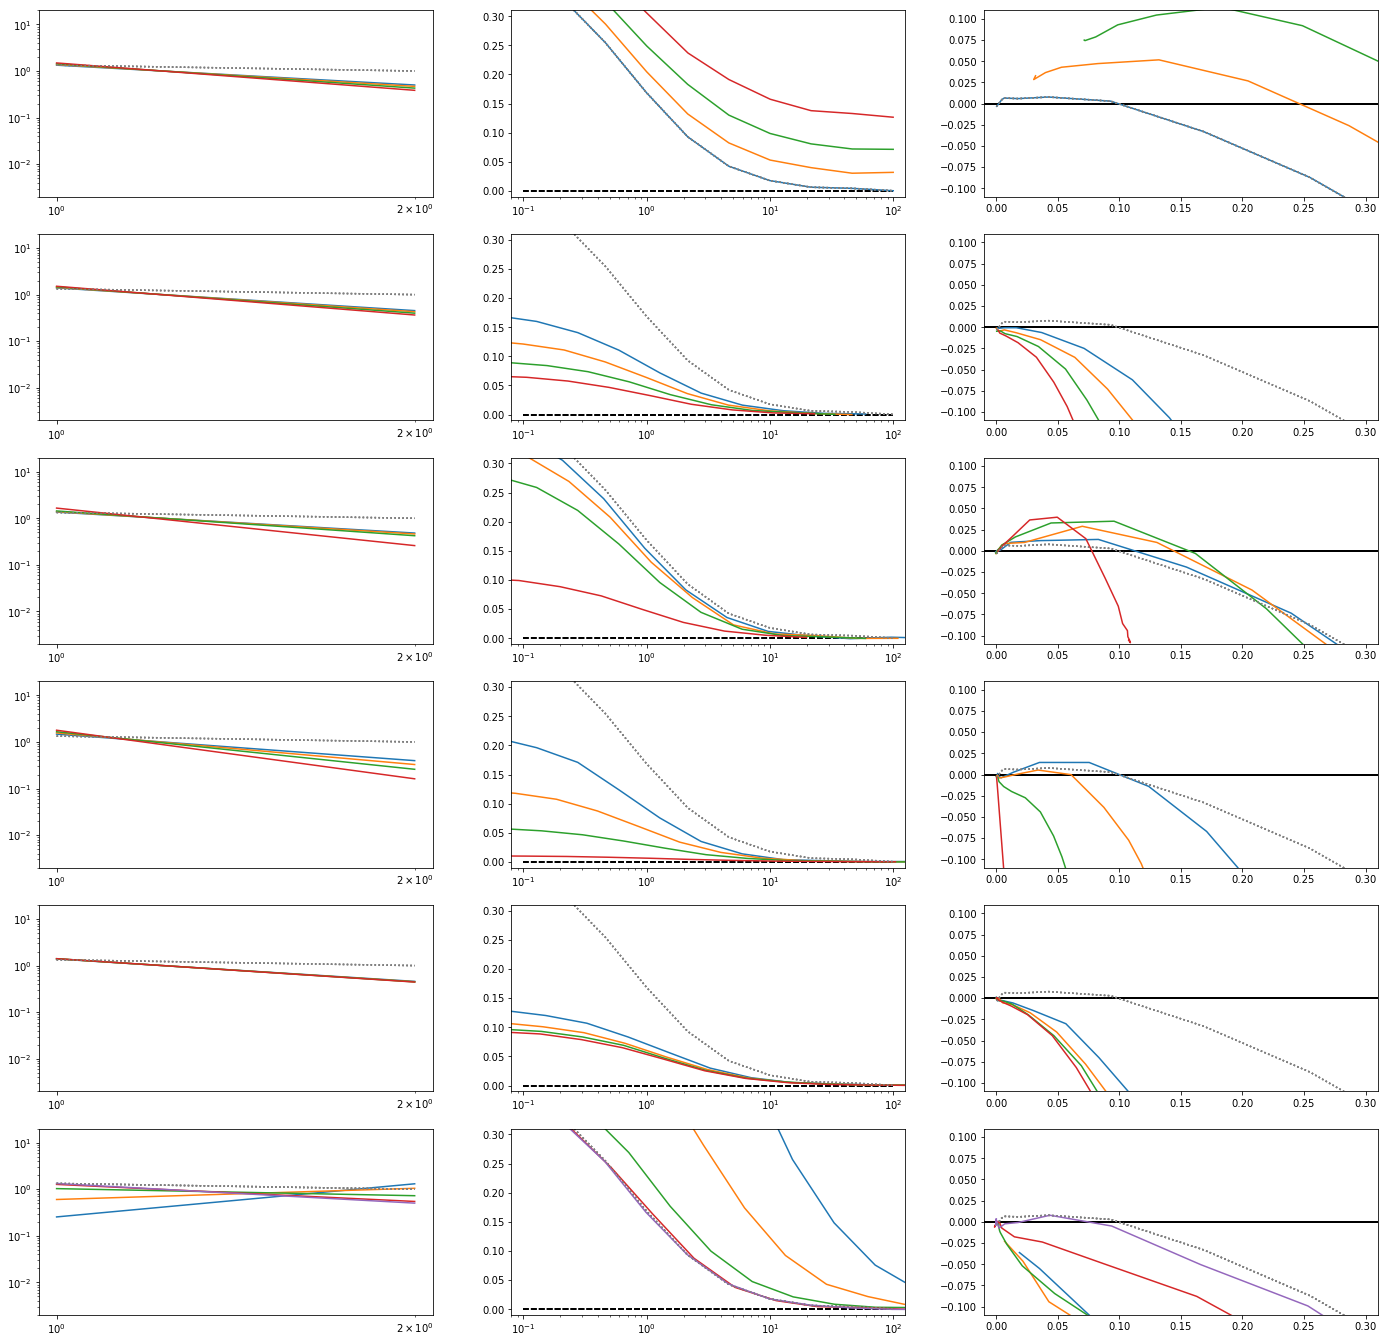

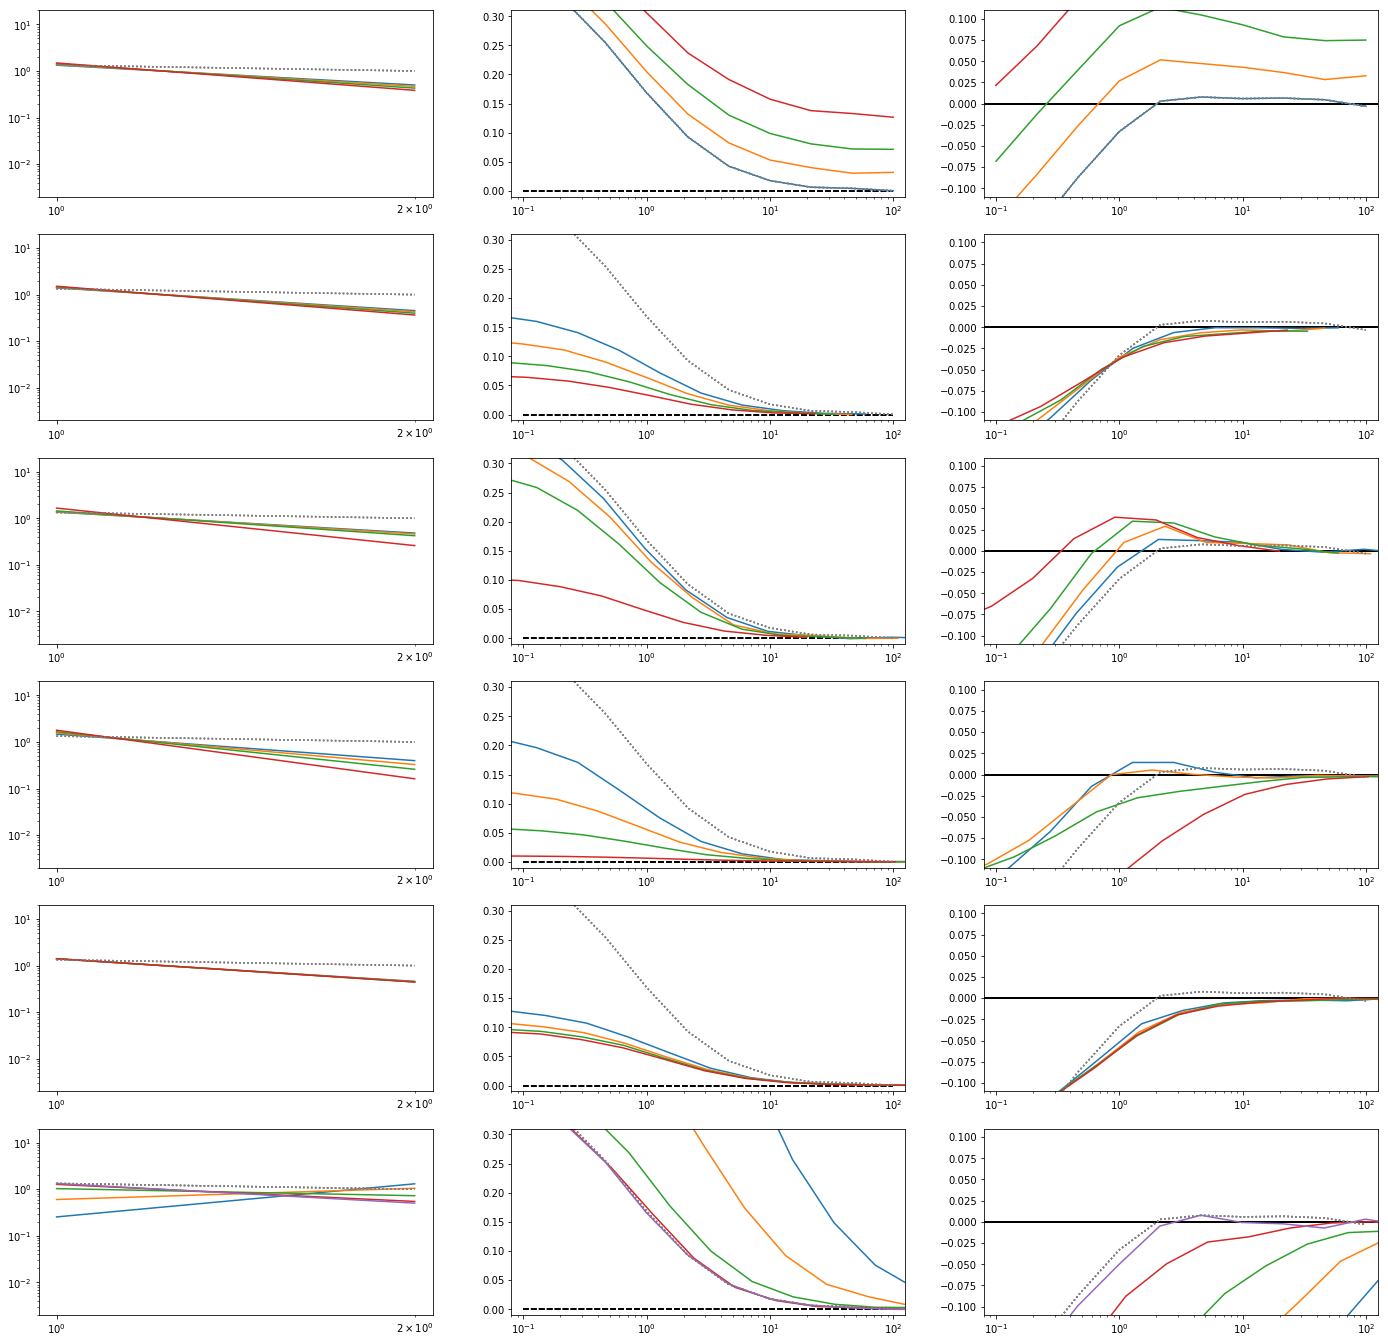

In [13]:
#cutoffs = [4, 20, 40]
cutoffs = [1]
n_rows = 6
n_cols = 2 + len(cutoffs)

for x_lohi in ['pic', 'd']:
    fig = plt.figure(figsize=(24,24))

    # BETA
    axes = [fig.add_subplot(n_rows, n_cols, i+1) for i in range(n_cols)]
    axes = plot_row(axes, *data_beta, cutoffs, n_samples=n_samples, x_lohi=x_lohi)

    # EXP
    axes = [fig.add_subplot(n_rows, n_cols, n_cols+i+1) for i in range(n_cols)]
    axes = plot_row(axes, *data_exp, cutoffs, n_samples=n_samples, x_lohi=x_lohi)

    # PWC
    for i_t, t in enumerate(t_list):
        axes = [fig.add_subplot(n_rows, n_cols, (2+i_t)*n_cols+i+1) for i in range(n_cols)]
        axes = plot_row(axes, *data_pwc[i_t], cutoffs, n_samples=n_samples, x_lohi=x_lohi)

    # Two-deme migration
    axes = [fig.add_subplot(n_rows, n_cols, 5*n_cols+i+1) for i in range(n_cols)]
    axes = plot_row(axes, *data_mig2, cutoffs, n_samples=n_samples, x_lohi=x_lohi)
    axes = plot_row(axes, *data_mig1, cutoffs, n_samples=n_samples, x_lohi=x_lohi)
    
    #plt.savefig('neutral_{}.pdf'.format(x_lohi))

# SLiM

## Import data

In [14]:
r_slim = 1e-8
mu = 1e-7
N = 1e3
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)
fsels_sweeps = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3])[:-1]
fsels_bgsel = np.logspace(-2,0,3)

In [15]:
fn_pattern = '../simulations/slim/{}_n-{}_fsel-{}_corrmerged.txt.gz'

In [19]:
def get_data_slim(fn):
    data = h.readcorr_normed(fn, n_samples)
    pi, sfs, pic, _, lhc, _ = data
    sfs /= pi
    d = dist*r_slim*pi / (2*mu)
    return d, sfs, pic, lhc

In [20]:
def plot_row_slim(axes, d, sfs, pic, lhc, cutoffs, n_samples=100, x_lohi='d'):
    '''
    Take a set of axes and plot the various data on them
    '''
    # The axis limits
    d_lim = [8e-2, (1/8)*1e3]
    pic_lim = [-0.01, 0.31]
    lhc_lim = [-0.11,0.11]


    #lhc_lim = [-0.021,0.021]
    #lhc_lim = [-0.11,0.025]
    sfs_lim = [2e-3, 2e1]
    
    # Plot SFS
    y0 = sfs
    x0 = np.arange(1, len(y0) + 1)        
    axes[0].loglog(x0, y0)
    axes[0].loglog(x0, 1/x0 + 1/(n_samples-x0), ':', color='0.5')
    axes[0].set_ylim(sfs_lim)

    # Plot Pi-correlation
    x1 = d
    y1 = pic
    axes[1].semilogx(x1, y1, )
    axes[1].hlines(0, 1e-1, 1e2, linestyle='dashed')
    axes[1].set_ylim(pic_lim)
    axes[1].set_xlim(d_lim)

    axes[1].semilogx(d_kingman, pic_kingman, ':', color='0.5')

    # Plot LoHi-Correlations for different cutoffs
    for j, cutoff in enumerate(cutoffs):
        ax = axes[2 + j]
        y = h.smooth(lhc[cutoff-1], 101)
        if x_lohi == 'd':
            x = d
            ax.semilogx(x,y)
            ax.semilogx(d_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
            ax.hlines(0, d_lim[0], d_lim[1])
            ax.set_xlim(d_lim)
        elif x_lohi == 'pic':
            x = y1
            # Don't use the d=0 bin
            ax.plot(x[1:],y[1:])
            ax.plot(pic_kingman, lhc_kingman[:,cutoff-1], ':', color='0.5')
            ax.hlines(0, pic_lim[0], pic_lim[1])
            ax.set_xlim(pic_lim)
        ax.set_ylim(lhc_lim)
            
    return axes


In [21]:
fn = fn_pattern.format('sweeps', n_samples, '0.0')
data_neut = get_data_slim(fn)

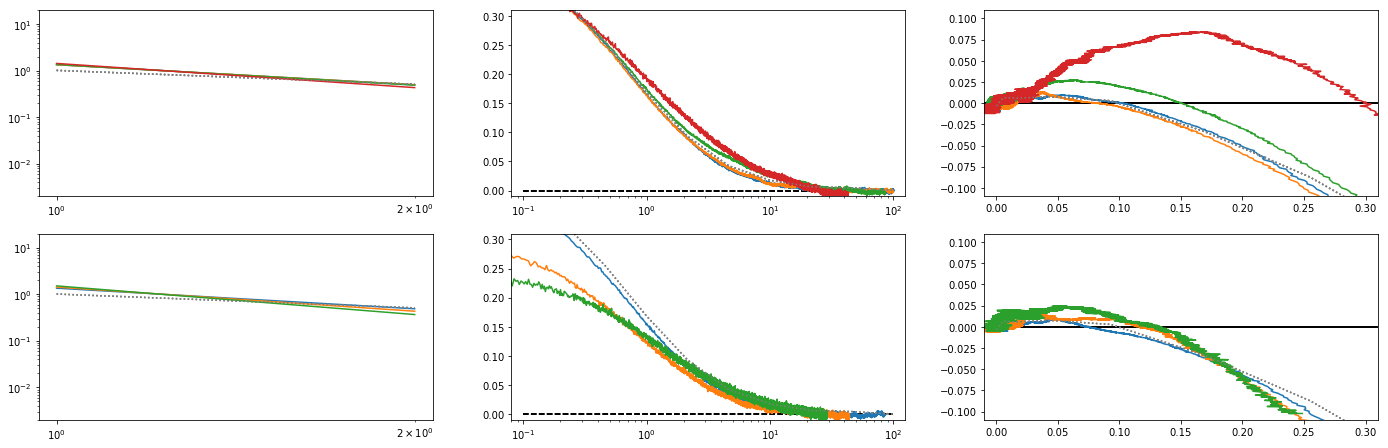

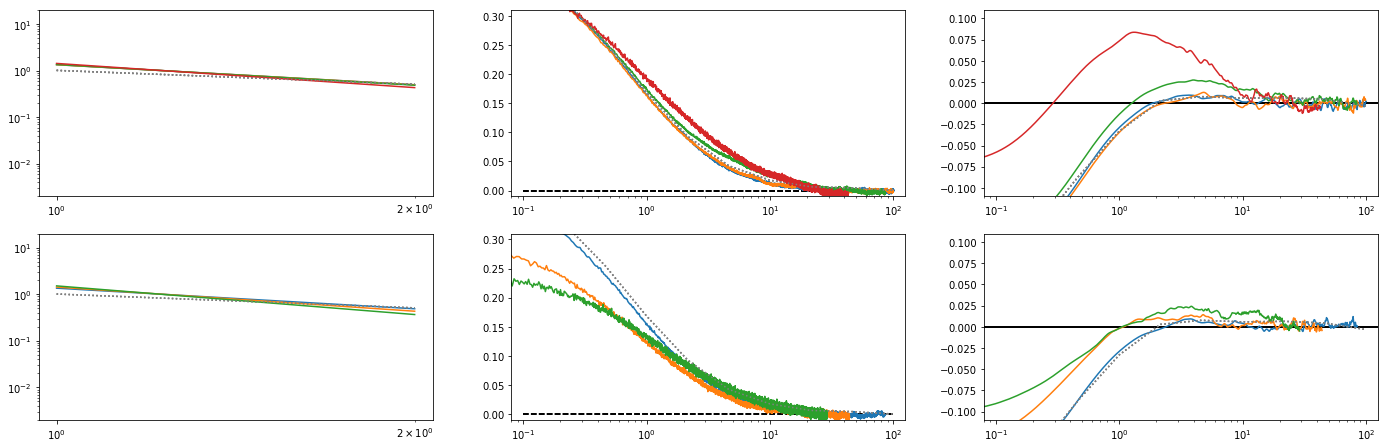

In [24]:
#cutoffs = [4, 20, 40]
cutoffs = [1]
n_rows = 6
n_cols = 2 + len(cutoffs)

for x_lohi in ['pic', 'd']:
    fig = plt.figure(figsize=(24,24))

    axes = [fig.add_subplot(n_rows, n_cols, i+1) for i in range(n_cols)]
    for fsel in fsels_sweeps:
        data = get_data_slim(fn_pattern.format('sweeps', n_samples, fsel))
        axes = plot_row_slim(axes, *data, cutoffs, x_lohi=x_lohi)
        axes = [fig.add_subplot(n_rows, n_cols, i+1) for i in range(n_cols)]
        
    axes = [fig.add_subplot(n_rows, n_cols, n_cols + i+1) for i in range(n_cols)]
    for fsel in fsels_bgsel:
        data = get_data_slim(fn_pattern.format('bgsel', n_samples, fsel))
        axes = plot_row_slim(axes, *data, cutoffs, x_lohi=x_lohi)
    plt.savefig('selection_{}.pdf'.format(x_lohi))